### Important
Run SLiM model with neutral mutations and compare the final SFS of that model with results from the deleterious variation simulations.

Does linkage to deleterious mutations affect the SFS? It should not produce any shifts - but perhaps it increases the variance?

How does neutral linkage simulation compare to neutral diffusion?

* constant Ne of different values
* Kimura's exact solution (starting from a fixed value of the allele frequency)

In [1]:
suppressPackageStartupMessages(library(tidyverse))

suppressPackageStartupMessages(source("../R/process_slim_output.R"))

Conflicts with tidy packages ---------------------------------------------------


In [2]:
traject_dir <- "../simulations/different_models"

In [3]:
library(parallel)

(gens <- c(1:10,25,50, seq(100, 2200, 300)))  # generations at which we dumped SLiM mutations
(models <- c("constant", "linear", "gravel")) # demographic models simulated
(dominances <- c("0.0", "0.1", "0.5"))        # dominance coefficients simulated

combinations <- expand.grid(gen=gens, model=models, h=dominances)

[1]    1    2    3    4    5    6    7    8    9   10   25   50  100  400  700
[16] 1000 1300 1600 1900 2200

[1] "constant" "linear"   "gravel"

[1] "0.0" "0.1" "0.5"

In [4]:
if (!file.exists("../tmp/neutral_mutations.Rds")) {

mutations_df_list <-
    mclapply(
        1 : nrow(combinations),
        function(i) {
            model <- combinations[i, "model"]
            gen <- as.integer(combinations[i, "gen"])
            dominance <- combinations[i, "h"]

            # load the whole SLiM output file first
            slim_file <- read_slim_file(file.path(traject_dir,
                                                  paste0(model,
                                                         "__h_", dominance,
                                                         "__init_nea_0.1__rep_1__dump_gen_",
                                                         gen,
                                                         ".txt")))

            # get the Ne of modern humans in this generation
            N <- filter(read_populations(slim_file), pop_id == "p3")$pop_size

            neutral_exonic <-
                read_mutations(slim_file, "m1", "p2") %>%
                mutate(model=model, kind="exonic", gen=gen, freq=count / (2 * N))

            neutral_nonexonic <-
                read_mutations(slim_file, "m2", "p2") %>%
                mutate(model=model, kind="nonexonic", gen=gen, freq=count / (2 * N))

            bind_rows(neutral_exonic, neutral_nonexonic) %>% mutate(h=dominance)
        },
        mc.cores=40 #detectCores()
    )
    
    mutations <- bind_rows(mutations_df_list) %>% mutate(gen=factor(gen))
    saveRDS(mutations, "../tmp/neutral_mutations.Rds")
    
} else {
    
mutations <- readRDS("../tmp/neutral_mutations.Rds")

}

In [7]:
mutations %<>% filter(kind == "nonexonic")

In [9]:
sfs <-
    suppressMessages(
        read_tsv("../input_data/all_tag_snps.EUR.merged.ALL.0.3_R2_cluster.1KG_phase3_essentials.median_af.bed.extended_LD",
             col_names=c("chr", "start", "stop", "AFA", "AFR",
                         "AMR", "EAS", "EUR", "PNG", "SAS",
                         "total_snps", "total_length"))
    ) %>%
    mutate(bin=findInterval(total_length, vec=c(0, 30000, 200000))) %>%
    filter(bin == 2) %>%
    select(AMR, EAS, EUR, SAS) %>%
    gather(pop, freq)

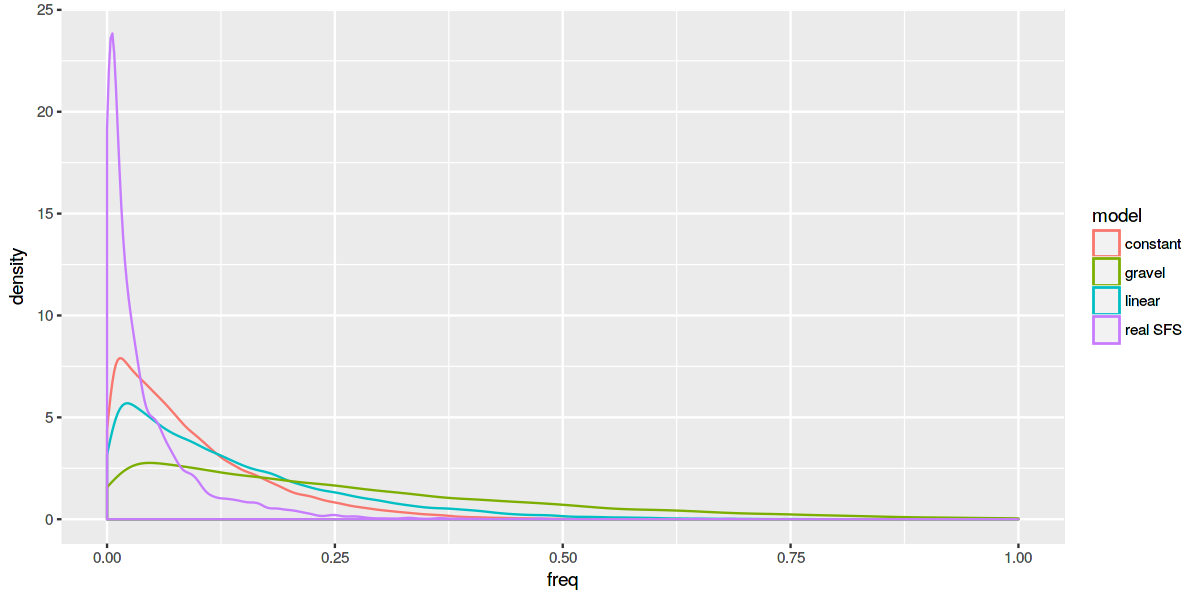

In [10]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot() +
    geom_density(aes(freq, group=model, color=model), data=filter(mutations, gen == 2200, kind == "nonexonic")) +
    geom_density(aes(freq, color=model, group=pop), data=mutate(filter(sfs, pop == "EUR"), model="real SFS"))

In [17]:
filter(mutations, gen == 2200) %>%
    group_by(model, kind, h) %>%
    summarize(mean(freq), min(freq), max(freq), n())

model,kind,h,mean(freq),min(freq),max(freq),n()
constant,nonexonic,0.0,0.11176311,5.000000e-05,0.6895500,32332
constant,nonexonic,0.1,0.08569451,5.000000e-05,0.6586500,25333
constant,nonexonic,0.5,0.07573655,5.000000e-05,0.5315000,16723
linear,nonexonic,0.0,0.14749224,1.468946e-05,0.9158000,23671
linear,nonexonic,0.1,0.12384664,1.468946e-05,0.8333921,16154
linear,nonexonic,0.5,0.12115221,1.468946e-05,0.7665697,11795
gravel,nonexonic,0.0,0.26539758,1.468946e-05,1.0000000,13914
gravel,nonexonic,0.1,0.24330175,1.468946e-05,1.0000000,9674
gravel,nonexonic,0.5,0.23890453,8.813679e-05,1.0000000,5393


In [16]:
options(repr.plot.width=10, repr.plot.height=8)

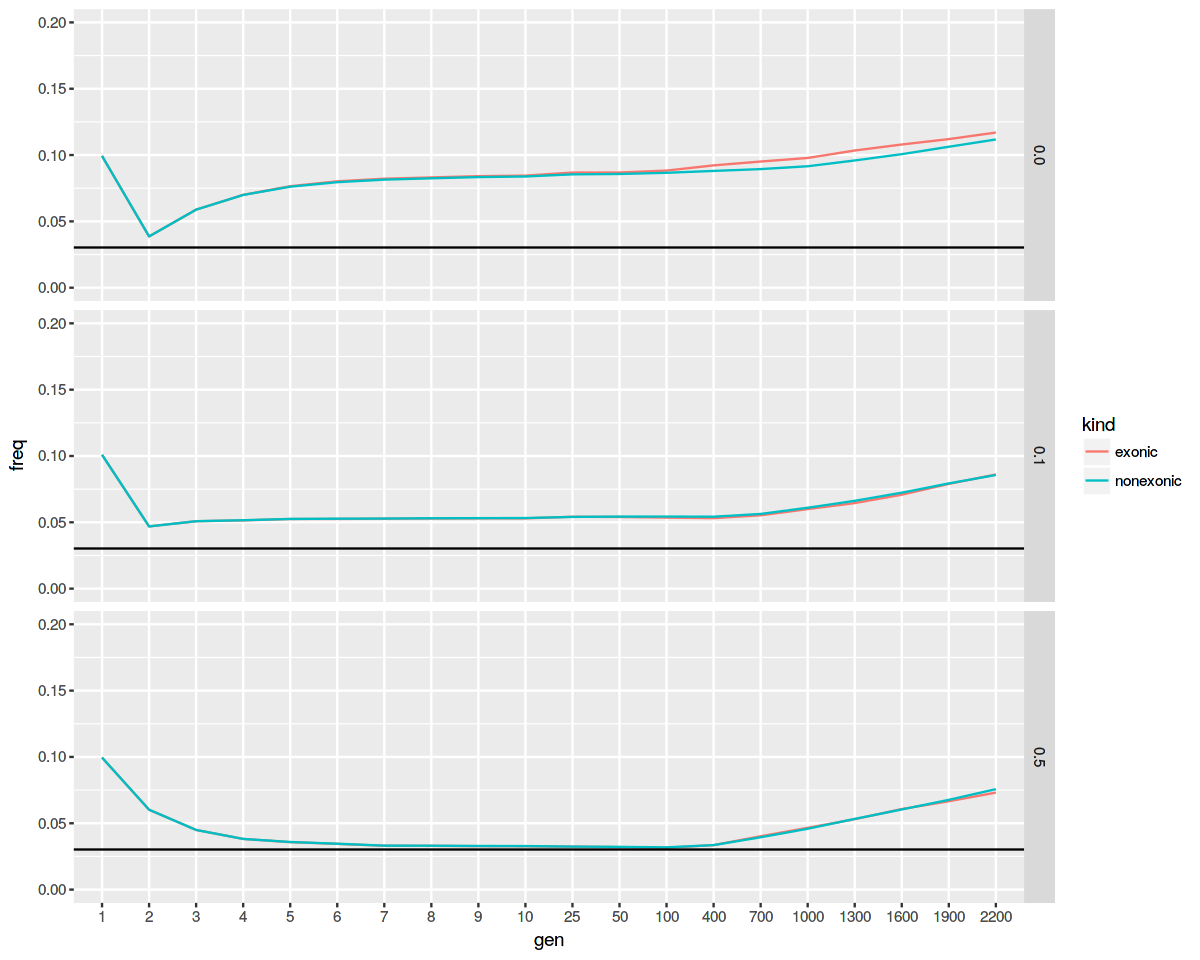

In [18]:
filter(mutations, model == "constant") %>%
    group_by(gen, kind, h) %>%
    summarise(freq=mean(freq)) %>%
    ggplot(aes(gen, freq, group=kind, color=kind)) + geom_line() + ylim(0, 0.2) +
    facet_grid(h ~ .) + geom_hline(yintercept = 0.03)

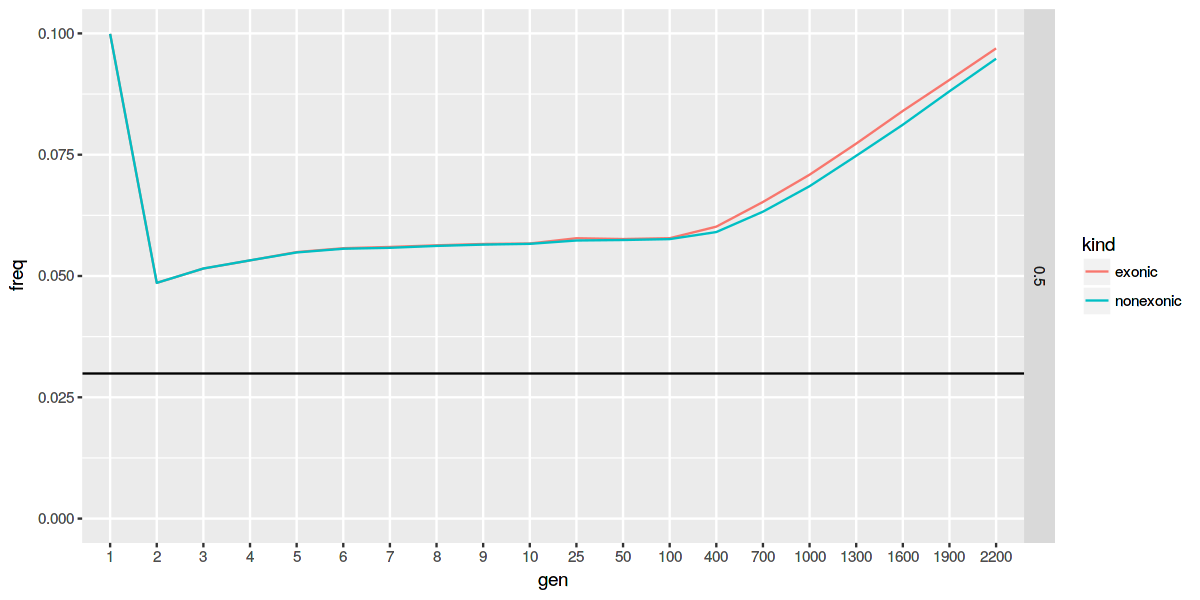

In [87]:
filter(mutations, model == "constant") %>%
    group_by(gen, kind, h) %>%
    summarise(freq=mean(freq)) %>%
    ggplot(aes(gen, freq, group=kind, color=kind)) + geom_line() + ylim(0, 0.1) +
    facet_grid(h ~ .) + geom_hline(yintercept = 0.03)

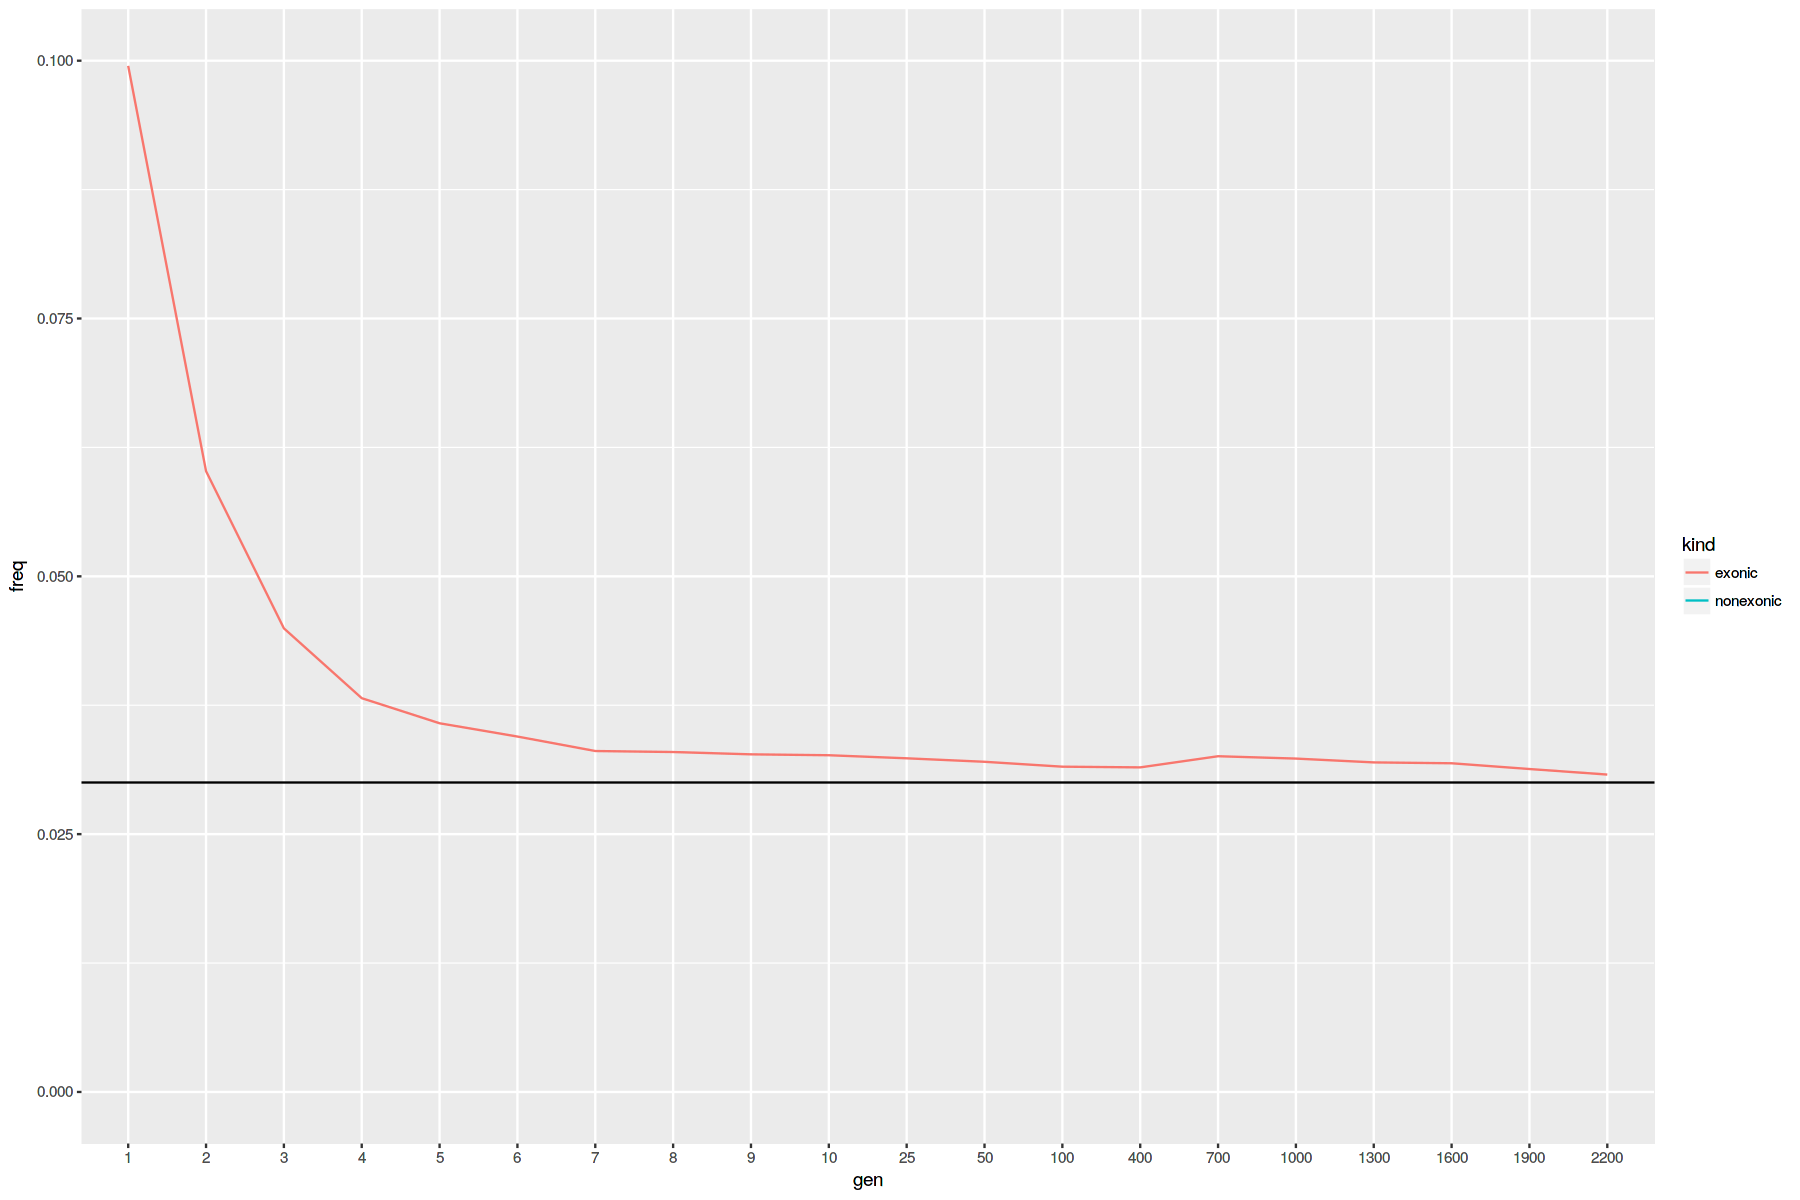

In [37]:
filter(mutations, model == "gravel") %>%
    group_by(gen, kind) %>%
    summarise(freq=sum(freq)/10000) %>%
    ggplot(aes(gen, freq, group=kind, color=kind)) + geom_line() + ylim(0, 0.1) + geom_hline(yintercept = 0.03)